In [12]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model
from matplotlib import pyplot as plt
import tensorflow as tf
import keras
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
import keras.layers as layers
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.models import model_from_json
from keras.models import Model




from keras.utils import pad_sequences
import os

def homePath(path):
    return os.path.join(os.path.expanduser("~"), path.strip("~/"))



#Model Creation 1
#Figure out how to do versioning effectively
individualInput = False
combinedInputPath = homePath("~/SPGenerations/")

GradesTokensName = ""
if individualInput:
    pathToTokenizedData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Tokenizer\\"
    pathToGradeData = "C:\\Users\\mcall\\OneDrive\\Desktop\\DummyOutput\\Grader\\"
else:
    pathToTokenizedData = os.path.join(combinedInputPath, "Tokens/")
    pathToGradeData = os.path.join(combinedInputPath, "Grades/")
if GradesTokensName == "":
    #Use newest folder for each

    #Get the newest folder for the tokens
    tokensFolders = os.listdir(pathToTokenizedData)
    tokensFolders.sort()
    pathToTokenizedData = os.path.join(pathToTokenizedData , tokensFolders[-1])

    #Get the newest folder for the grades
    gradesFolders = os.listdir(pathToGradeData)
    gradesFolders.sort()
    pathToGradeData = os.path.join(pathToGradeData,  gradesFolders[-1])
else:
    pathToTokenizedData = os.path.join(pathToTokenizedData, GradesTokensName)
    pathToGradeData = os.path.join(pathToGradeData, GradesTokensName)





modelOutputPath = homePath("~/SPGenerations/Models")

#Load the data
#tokenized data is in tokenizedData.pkl, has tokenizer obj in tokenizer.json

#Load the tokenizer
with open(pathToTokenizedData+ "/tokenizer.json", "r") as f:
    tokenizer = tokenizer_from_json(f.read())



#Load the tokenized data
with open(pathToTokenizedData + "/tokenizedData.pkl", "rb") as f:
    tokenizedData = pickle.load(f)

#Load the grade data
#gradeData is a dict with keys as the file names and values as the grades
with open(pathToGradeData + "/grades.pkl", "rb") as f:
    gradeData = pickle.load(f)

combinedDF = pd.merge(tokenizedData, gradeData, on = "Path")
print (combinedDF)







                                             tokenCode  \
0    [38, 53, 2, 38, 41, 2, 52, 123, 3, 161, 3, 104...   
1    [38, 53, 2, 38, 41, 2, 52, 123, 3, 161, 3, 104...   
2    [38, 53, 2, 38, 509, 2, 52, 68, 3, 890, 38, 36...   
3    [38, 53, 2, 38, 41, 2, 52, 68, 38, 75, 2, 52, ...   
4    [38, 53, 2, 38, 509, 2, 52, 68, 3, 890, 38, 36...   
..                                                 ...   
877  [38, 405, 2, 38, 959, 2, 38, 633, 2, 38, 828, ...   
878  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   
879  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   
880  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   
881  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   

                                      Path  fileGrade  
0                /3584343/conftest.py/1.py  50.000000  
1                /3584343/conftest.py/0.py  40.000000  
2       /3584343/tests/test_engine.py/5.py  47.692308  
3    /3584343/tests/test_graphson2.py/0.py  40.000000  
4       /3584343/tests/

In [13]:
#Padding

maxLen = 1000
#get rid of the ones that are too long
combinedDF = combinedDF[combinedDF["tokenCode"].apply(lambda x: len(x)) <= maxLen]

#Pad the sequences
combinedDF["tokenCode"] = pad_sequences(combinedDF["tokenCode"], maxlen = maxLen, padding = "post", truncating = "post").tolist()

print (combinedDF)




                                             tokenCode  \
3    [38, 53, 2, 38, 41, 2, 52, 68, 38, 75, 2, 52, ...   
4    [38, 53, 2, 38, 509, 2, 52, 68, 3, 890, 38, 36...   
10   [38, 53, 2, 38, 509, 2, 52, 68, 3, 890, 38, 36...   
13   [38, 53, 2, 38, 509, 2, 52, 68, 3, 890, 38, 36...   
17   [38, 405, 2, 38, 41, 2, 52, 68, 38, 75, 2, 13,...   
..                                                 ...   
877  [38, 405, 2, 38, 959, 2, 38, 633, 2, 38, 828, ...   
878  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   
879  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   
880  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   
881  [38, 828, 2, 38, 633, 2, 38, 405, 2, 38, 959, ...   

                                      Path  fileGrade  
3    /3584343/tests/test_graphson2.py/0.py  40.000000  
4       /3584343/tests/test_engine.py/1.py  41.538462  
10      /3584343/tests/test_engine.py/2.py  46.076923  
13      /3584343/tests/test_engine.py/0.py  40.000000  
17      /3584343/tests/

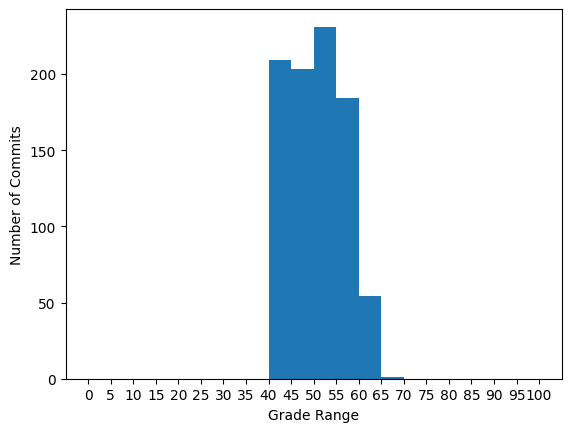

In [6]:
#create a chart of the grades
graph = plt.hist(combinedDF['fileGrade'], bins=20, range=(0, 100))
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
plt.xlabel("Grade Range")
plt.ylabel("Number of Commits")
plt.show()



In [9]:
#test to make sure gpu is detected and save as bool
gpu_detected = tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [16]:
#if (not gpu_detected):
#    print("GPU not detected, using CPU")

model = Sequential()
model.add(Embedding(tokenizer.num_words, 1024, input_length=maxLen))
model.add(layers.Conv1D(2048, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Reshape((1, 2048)))
model.add(layers.Bidirectional(LSTM(1024, return_sequences=True))) 
model.add(Dropout(0.38479930887149405))
model.add(layers.Bidirectional(LSTM(512)))
model.add(layers.Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1, activation='linear'))

print(model.summary())

model.compile(loss='mean_squared_logarithmic_error', optimizer='Adam', metrics=['mse', 'mae', 'mape', 'accuracy'])

hist = model.fit(combinedDF["tokenCode"].tolist(), combinedDF["fileGrade"].tolist(), epochs=100, batch_size=32,verbose = 1)

plt.subplot(211)
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='test')
plt.legend()
plt.show()

#Save the model in timestamp folder and with tokenizer
timestamp = str(pd.Timestamp.now())
if not os.path.exists(modelOutputPath):
    os.mkdir(modelOutputPath)
if not os.path.exists(modelOutputPath + "/" + timestamp):
    os.mkdir(modelOutputPath + "/" + timestamp)
model.save(modelOutputPath + "/" + timestamp + "/model.h5")
with open(modelOutputPath + "/" + timestamp + "/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1000, 1024)        10240000  
                                                                 
 conv1d_2 (Conv1D)           (None, 998, 2048)         6293504   
                                                                 
 global_max_pooling1d_2 (Gl  (None, 2048)              0         
 obalMaxPooling1D)                                               
                                                                 
 reshape_2 (Reshape)         (None, 1, 2048)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 1, 2048)           25174016  
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 1, 2048)          